# Задача извлечения фрагмента из текста по запросу

🎯 **Цель работы**

Разработка модели, которая по входной паре `текст документа` и `наименование пункта анкеты` будет возвращать соответствующий `фрагмент текста из данного документа`. 

📁 **Данные**

Модель должна помочь отделу госзакупок извлекать нужный кусок текста из документа для того, чтобы сформировать анкету заявки. То, какой именно фрагмент текста нужно извлечь, зависит от пункта анкеты, соответствующего документу.
Всего в каждом документе есть 1 из 2-х пунктов анкеты, по которым необходимо извлекать кусочки из текста:
- обеспечение исполнения контракта,
- обеспечение гарантийных обязательств

Данные для обучения в формате `json` имеют следующие поля:
- `id`: `int` - id документа
-  `text`: `str` - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: `str` - название пункта анкеты, может принимать одно из двух значений - `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`
- `extracted_part`: `dict` следующего формата:
    ```
    {
        'text': [фрагмент текста из поля 'text', соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
   ```

🥇 **Оценка**

Для оценки решения используется метрика `Accuracy`: доля наблюдений, в которых извлеченный моделью фрагмент текста полностью соответствует фактически требуемому фрагменту.

In [7]:
!pip install -q -r requirements.txt

In [10]:
# загружаем датасет
import json

train_path = "dataset/train.json"
test_path = "dataset/test.json"
with open(train_path, "r", encoding="utf-8") as train_file:
    train_datas = json.load(train_file)
with open(test_path, "r", encoding="utf-8") as test_file:
    test_datas = json.load(test_file)

## Часть 1. Разведочный анализ данных

В этой части представляется небольшой sanity check данных, чтобы убедиться, что все данные представлены корректно, а также проводится разведочный анализ данных (распределение лейблов, размер датасета, распределение длин текстов, похожесть текстов).

In [11]:
from scripts.eda import ExploratoryDataAnalysis
eda = ExploratoryDataAnalysis()

Для начала проверим, все ли данные в тренировочном датасете представлены корректно.

In [12]:
eda.sanity_check(train_datas)

Count of `text` that have more than one element: 0
Count of `answer_start` that have more than one element: 0
Count of `answer_end` that have more than one element: 0
Count of examples where `answer_start` and `answer_end` are not correct: 0


Как видно, в тренировочных данных нет таких экземпляров, где в `extracted_part` списки `text`, `answer_start` и `answer_end` содержат больше одного элемента. Также мы убедились, что индексы внутри `answer_start` и `answer_end` действительно соответствуют индексам извлеченного фрагмента в `text`.

Теперь посмотрим на размер датасета и лейблы (пункты анкеты, по которым требуется извлекать фрагмент из текста):

In [13]:
eda.explore_labels_balance(train_datas)

Data Size: 1799


Labels Balance
	- обеспечение исполнения контракта: 0.55
	- обеспечение гарантийных обязательств: 0.45


In [14]:
eda.explore_labels_balance(test_datas)

Data Size: 318


Labels Balance
	- обеспечение исполнения контракта: 0.55
	- обеспечение гарантийных обязательств: 0.45


И в тренировочном, и в тестовом датасете тексты почти равномерно распределены по лейблам. Размер тренировочной выборки небольшой, всего 1799 размеченных текстов (нам также необходимо будет какую-то часть данных их них оставить на валидацию моделей).

Теперь взглянем на длины текстов в тренировочном и тестовом датасетах. Длины будем измерять по символам и по токенам (токены для удобства получим простым разбиением с помощью `.split()`):

Texts Lengths
	Lengths: symbols
		Average length:			 2301
		Median length:			 2524
		Minimum length:			 1002
		Maximum length:			 3212
		90-percentile:			 2657
		99-percentile:			 2763
		Min length texts (count):	 2
	Lengths: base tokens received by `.split()` method
		Average length:			 275
		Median length:			 300
		Minimum length:			 80
		Maximum length:			 367
		90-percentile:			 325
		99-percentile:			 344
		Min length texts (count):	 2


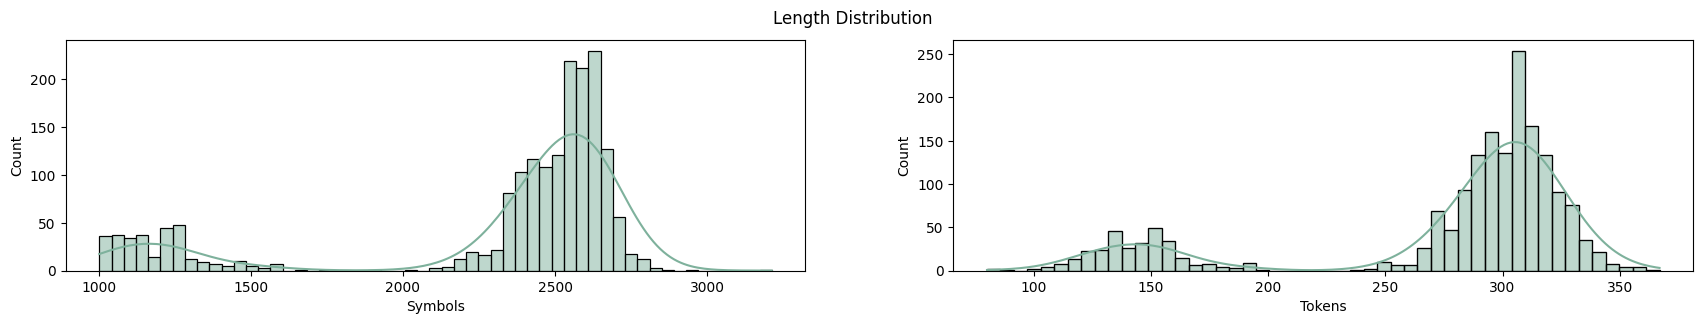

In [15]:
# длины текстов в тренировочной выборке
texts = [data["text"] for data in train_datas]
eda.explore_texts_lengths(texts)

Texts Lengths
	Lengths: symbols
		Average length:			 2305
		Median length:			 2518
		Minimum length:			 1002
		Maximum length:			 2875
		90-percentile:			 2665
		99-percentile:			 2851
		Min length texts (count):	 1
	Lengths: base tokens received by `.split()` method
		Average length:			 275
		Median length:			 299
		Minimum length:			 106
		Maximum length:			 360
		90-percentile:			 323
		99-percentile:			 338
		Min length texts (count):	 1


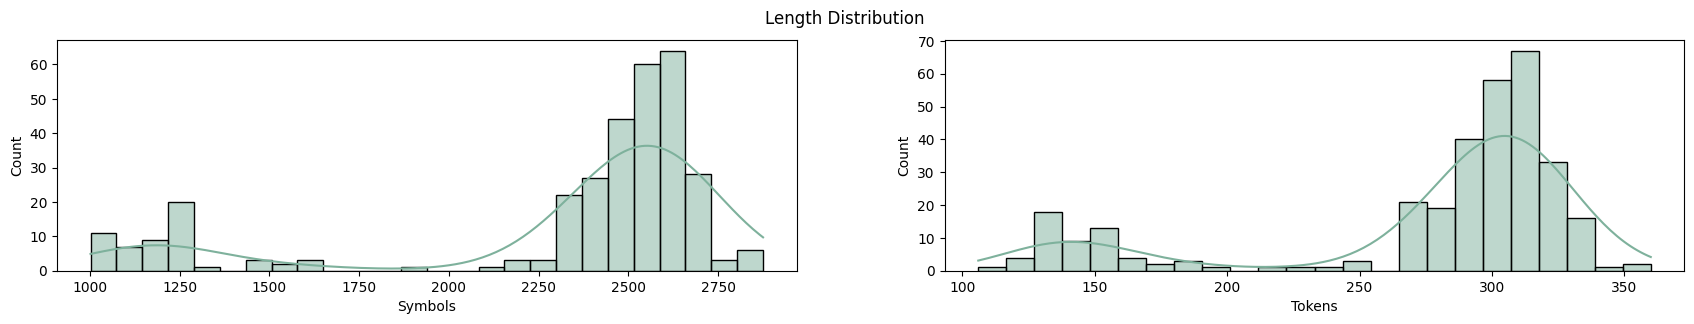

In [16]:
# длины текстов в тестовой выборке
texts = [data["text"] for data in test_datas]
eda.explore_texts_lengths(texts)

Распределение длин и в тренировочной, и в тестовой выборках "двугорбое": есть достаточно много длинных текстов (примерно от 2300 до 2750 символов), чуть поменьше коротких текстов (примерно от 1000 до 1500) и почти нет текстов средней длины (примерно от 1500 до 2300). Заметно также, что в выборках нет текстов длиной меньше 1000 символов, и текстов с самой маленькой длиной встречается всего 2 (в тренировочной выборке).

Стоит отметить, что распределение длин по токенам и по символам очень похоже, значит, тексты условно "нормальные" с точки зрения длин слов внутри них.

Интерес вызывает также распределение длин извлеченных фрагментов:

Texts Lengths
	Lengths: symbols
		Average length:			 87
		Median length:			 84
		Minimum length:			 0
		Maximum length:			 302
		90-percentile:			 165
		99-percentile:			 231
		Min length texts (count):	 307
	Lengths: base tokens received by `.split()` method
		Average length:			 10
		Median length:			 11
		Minimum length:			 0
		Maximum length:			 40
		90-percentile:			 20
		99-percentile:			 30
		Min length texts (count):	 307


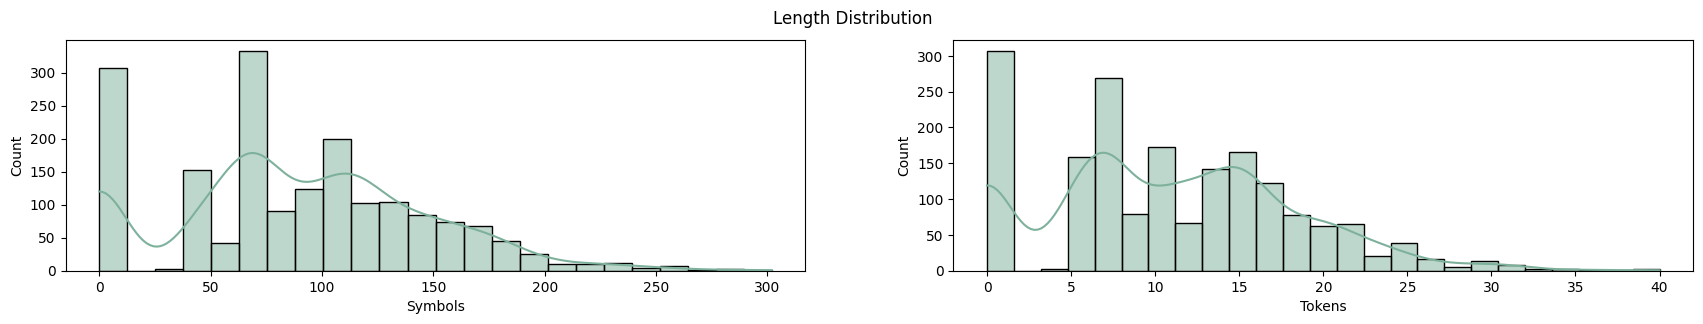

In [17]:
texts = [data["extracted_part"]["text"][0] for data in train_datas]
eda.explore_texts_lengths(texts)

Из анализа распределения длин мы видим, что в извлеченных фрагментах встречается 307 экземпляров с нулевой длиной. В остальном распределение выглядит смещенным вправо "с длинным хвостом", то есть длинных извлеченных фрагментов встречается довольно мало (максимальная длина фрагмента составляет 302 символа).

Теперь стоит посмотреть на то, не встречаются ли внутри текстов в тренировочной выборке повторяющиеся или очень похожие экземпляры. Для вычисления сходства двух текстовых последовательностей воспользуемся классом `SequenceMatcher()` модуля `difflib` и сравним тексты в тренировочной выборке, посчитав меру их сходства. Чтобы воспроизвести подсчет меры схожести, необходимо раскомментировать ячейку ниже и запустить ее (результат вычислений сохранится в текущую директорию под названием `similarities.csv`). NOTE: воспроизведение подсчета занимает много времени!

In [ ]:
# from scripts.eda import collect_similarities
# texts = [data["text"] for data in train_datas]
# collect_similarities("similarities.csv", texts)

Так как все подсчеты меры схожести произведены заранее, в текущей директории уже содержится готовый файл `similarities.csv`, и мы можем посмотреть на результат:

In [18]:
import pandas as pd
similarities_df = pd.read_csv("similarities.csv", low_memory=False)
print(similarities_df[similarities_df["sim_score"] == 1])

Empty DataFrame
Columns: [text_1, text_2, sim_score]
Index: []


В тренировочных данных нет полностью одинаковых текстов. Теперь посмотрим, сколько пар текстов похожи больше, чем на 90%:

In [19]:
print(similarities_df[similarities_df["sim_score"] > 0.9].shape)

(3832, 3)


3832 пары текстов очень похожи (скорее всего, содержат именно одинаковую структуру самого документа и отличаются лишь номерами/адресами/наименованиями учреждений и пр.). Так как среди таких похожих документов есть целые группы документов, необходимо произвести некоторые преобразования, чтобы получить количество похожих документов всего (при этом мы не будем включать сюда те похожие документы, у которых разные лейблы или разные извлеченные фрагменты):

In [20]:
from scripts.eda import get_similar_texts
similar_texts = get_similar_texts(similarities_df, train_datas)
print("Count of similar texts:", len(similar_texts))

Count of similar texts: 252


Cохраним отфильтрованный тренировочный датасет.

In [21]:
train_datas_filtered = [data for data in train_datas if train_datas.index(data) not in similar_texts]

with open("train_filtered.json", "w", encoding="utf-8") as output_f:
    json.dump(train_datas_filtered, output_f)

print("Filtered train dataset size: ", len(train_datas_filtered))

Filtered train dataset size:  1547


В отфильтрованном датасете осталось 1547 документов.

>Забегая вперед, нужно сказать, что при проведении экспериментов с отфильтрованным датасетом не удалось добиться улучшения качества ни для одного из подходов. Скорее всего, отфильтрованный датасет слишком маленький для успешного обучения.

## Часть 2. Подходы к решению задачи

Здесь рассматриваются возможные подходы к решению задачи, включая их описание, обучение моделей и оценку их результативности.

In [22]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Extractive Question-Answering

Наша задачу можно отнести к задаче Extractive QA, суть которой сводится к поиску ответа на вопрос в заданном тексте (при этом ответ является фрагментом самого текста). Стандартный алгоритм решения такой задачи выглядит следующим образом: вопрос и текст подаются на вход энкодеру (чаще всего - BERT-like) как две последовательности, разделенные токеном `[SEP]`, в результате получаются эмбеддинги для каждого токена. Далее во время дообучения модели добавляется линейный слой, на котором предсказываются начальная и конечная позиция необходимого фрагмента (ответа), то есть, по сути, два класса для каждого эмбеддинга. 

Для нашей задачи возьмем предобученную модель [`cointegrated/rubert-tiny2`](https://huggingface.co/cointegrated/rubert-tiny2) и дообучим ее на задачу извлечения фрагмента текста, добавив линейный слой.

In [23]:
from scripts.utils import add_stratifing_label
from scripts.ExtractiveQA import preprocess as EQA_preprocess
from scripts.ExtractiveQA import train as EQA_train

# делим датасет на тренировочный и валидационный
# при этом обязательно добавляем стратификацию одновременно и по лейблу, и по наличию/отсутствию текста в extracted_part
train_set, valid_set = train_test_split(
    train_datas,
    test_size=0.2,
    shuffle=True,
    random_state=SEED,
    stratify=add_stratifing_label(train_datas))

In [24]:
# загружаем модель и токенизатор
MODEL_NAME = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_bert = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Модель `cointegrated/rubert-tiny2` может принимать на вход до 2048 токенов, но мы можем не делать инпуты для модели такими длинными, если посмотрим на длины токенизированных текстов:

In [25]:
lengths = []
for data in train_datas:
    end_char = data["extracted_part"]["answer_end"][0]
    tokenized = tokenizer(data["text"][:end_char+1])
    lengths.append(len((tokenized["input_ids"])))
print(max(lengths))

476


Максимальная длина тех частей текстов, которые ограничены `answer_end` (то есть тех частей, в которые входит извлекаемый фрагмент), равна 476, то есть мы можем оставить стандартную длину инпута BERT-like моделей в 512 токенов. Таким образом, мы не будем делать инпуты слишком длинными, и при этом если часть текстов "обрежется", то в них все равно будет содержатся нужный фрагмент.

In [26]:
MAX_LEN = 512

In [27]:
#строим датасеты и лоадеры
train_dataset = EQA_preprocess.ExtractiveQADataset(tokenizer=tokenizer, datas=train_set)
valid_dataset = EQA_preprocess.ExtractiveQADataset(tokenizer=tokenizer, datas=valid_set)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

In [ ]:
#на первом этапе обучения замораживаем bert модель
for param in model_bert.parameters():
    param.requires_grad = False

model = EQA_train.ExtractiveQAModel(model_bert, num_classes=2).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = CrossEntropyLoss().to(DEVICE)

EQA_train.train_epochs(
    epochs=1000, 
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    criterion=criterion,
    mode="freeze"
)

In [ ]:
#на втором этапе размораживаем модель
for param in model_bert.parameters():
    param.requires_grad = True

model = EQA_train.ExtractiveQAModel(model_bert, num_classes=2, dropout=0.5).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = CrossEntropyLoss().to(DEVICE)

model_path = "models/ExtractiveQA/freeze/state_dict_model.pth"
model.load_state_dict(torch.load(model_path))
optimizer_path = "models/ExtractiveQA/freeze/state_dict_optimizer.pth"
optimizer.load_state_dict(torch.load(optimizer_path))
scheduler_path = "models/ExtractiveQA/freeze/state_dict_scheduler.pth"
scheduler.load_state_dict(torch.load(scheduler_path))

EQA_train.train_epochs(
    epochs=1000, 
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    criterion=criterion,
    mode="unfreeze"
)

Посмотрим на результаты обучения:

In [28]:
from scripts.utils import plot_lurning_curve

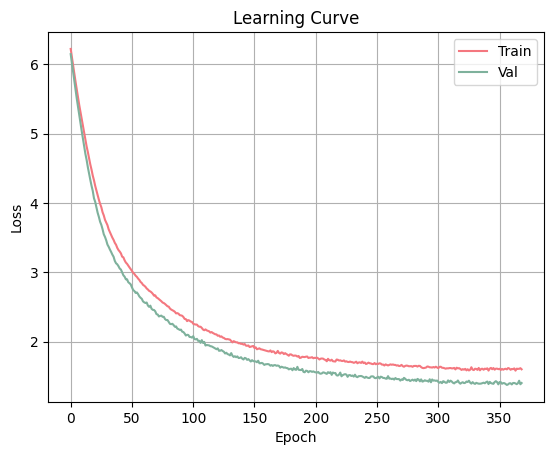

In [29]:
# первый этап обучения
with open("models/ExtractiveQA/freeze/info.json", "r") as info_file:
    info = json.load(info_file)
plot_lurning_curve(info["train_losses"], info["valid_losses"], "Loss")

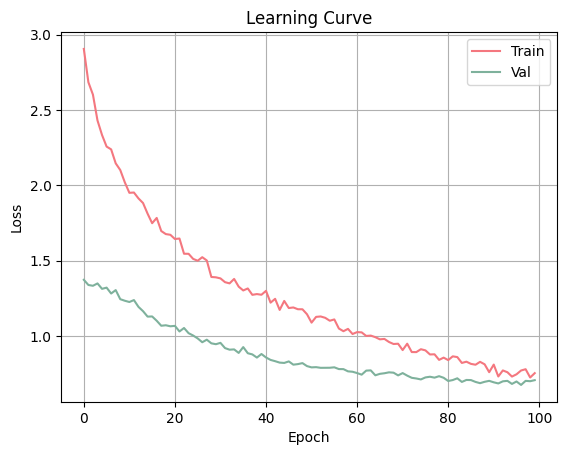

In [30]:
# второй этап обучения
with open("models/ExtractiveQA/unfreeze/info.json", "r") as info_file:
    info = json.load(info_file)
plot_lurning_curve(info["train_losses"], info["valid_losses"], "Loss")

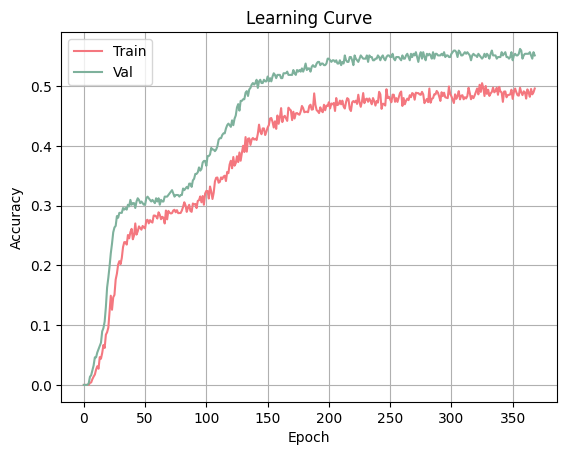

In [31]:
# первый этап обучения
with open("models/ExtractiveQA/freeze/info.json", "r") as info_file:
    info = json.load(info_file)
plot_lurning_curve(info["train_accuracy"], info["valid_accuracy"], "Accuracy")

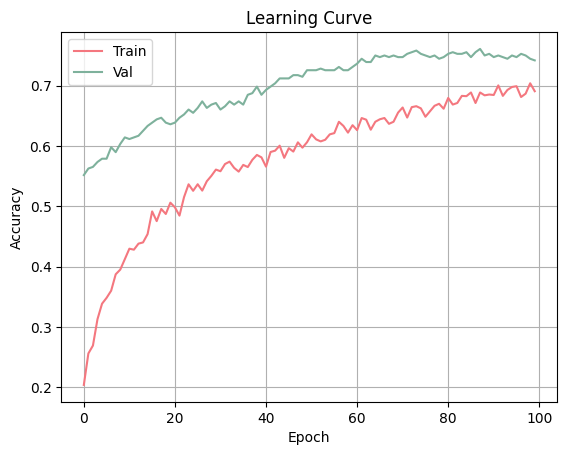

In [32]:
# второй этап обучения
with open("models/ExtractiveQA/unfreeze/info.json", "r") as info_file:
    info = json.load(info_file)
plot_lurning_curve(info["train_accuracy"], info["valid_accuracy"], "Accuracy")

Метрика на тестовой выборке стабильно выше, чем на тренировочной. Так как при разбиении на выборки не должно было быть проблем (мы применили и shuffle, и stratifying), скорее всего, проблема в каких-либо параметрах модели и если провести еще эксперименты, возможно, получится улучшить поведение модели. Тем не менее, модель на тестовой выборке к концу обучения показывает метрику около 0.75, что выглядит неплохо. 

### 2. Token Classification

Еще один способ решить задачу - это применить Token Classification подход. Он в общем смысле равнозначен задаче NER (Named Entity Recognition), когда модель предсказывает определенный лейбл каждому токену. Здесь алгоритм будет выглядеть так: текст подается на вход энкодеру (например, BERT-like модели), получаются эмбеддинги для каждого токена; далее во время дообучения добавляется линейный слой, на котором для каждого эмбеддинга предсказывается лейбл (то есть наш запрос) или его отсутствие. В нашем случае таких лейблов будет три: два для `обеспечение исполнения контракта` и `обеспечение гарантийных обязательств` и один - для обозначения отсутствия признака, или `NO-LABEL`.

Для нашей задачи также возьмем предобученную модель [`cointegrated/rubert-tiny2`](https://huggingface.co/cointegrated/rubert-tiny2) и дообучим ее на задачу классификации токенов, добавив линейный слой. Так как мы используем ту же модель с тем же токенизатором, то параметр `MAX_LEN` тоже оставляем 512.

In [35]:
from scripts.TokenCLF import preprocess as TC_preprocess
from scripts.TokenCLF import train as TC_train

In [36]:
LABEL2ID = {
    "NO-LABEL": 0,
    "обеспечение исполнения контракта": 1, 
    "обеспечение гарантийных обязательств": 2
}
MAX_LEN = 512

In [37]:
# загружаем модель и токенизатор
MODEL_NAME = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_bert = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
#строим датасеты и лоадеры
train_dataset = TC_preprocess.TokenCLFDataset(tokenizer=tokenizer, datas=train_set)
valid_dataset = TC_preprocess.TokenCLFDataset(tokenizer=tokenizer, datas=valid_set)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

In [ ]:
#на первом этапе обучения замораживаем bert модель
for param in model_bert.parameters():
    param.requires_grad = False

model = TC_train.TokenCLFModel(model_bert)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = CrossEntropyLoss().to(DEVICE)

TC_train.train_epochs(
    epochs=1000, 
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    criterion=criterion,
    mode="freeze"
)

In [ ]:
#на втором этапе размораживаем модель
for param in model_bert.parameters():
    param.requires_grad = True

model = TC_train.TokenCLFModel(model_bert)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = CrossEntropyLoss().to(DEVICE)

model_path = "models/TokenCLF/freeze/state_dict_model.pth"
model.load_state_dict(torch.load(model_path))
optimizer_path = "models/TokenCLF/freeze/state_dict_optimizer.pth"
optimizer.load_state_dict(torch.load(optimizer_path))
scheduler_path = "models/TokenCLF/freeze/state_dict_scheduler.pth"
scheduler.load_state_dict(torch.load(scheduler_path))

EQA_train.train_epochs(
    epochs=1000, 
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    criterion=criterion,
    mode="unfreeze"
)

Теперь посмотрим на графики обучения:

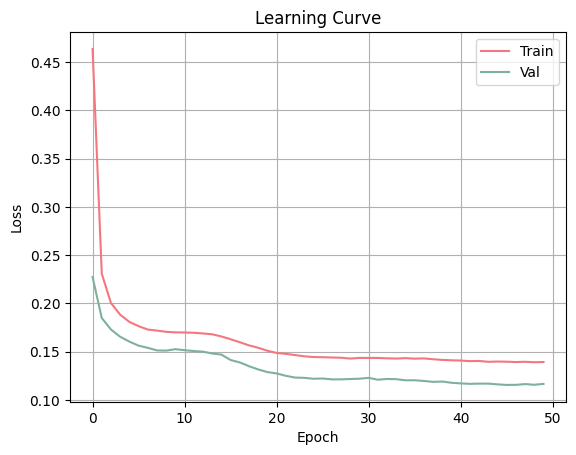

In [39]:
# первый этап обучения
with open("models/TokenCLF/freeze/info.json", "r") as info_file:
    info = json.load(info_file)
plot_lurning_curve(info["train_losses"], info["valid_losses"], "Loss")

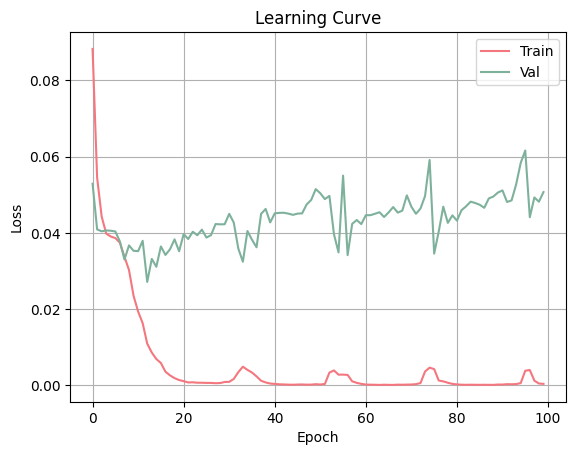

In [46]:
# второй этап обучения
with open("models/TokenCLF/unfreeze/info.json", "r") as info_file:
    info = json.load(info_file)
plot_lurning_curve(info["train_losses"], info["valid_losses"], "Loss")

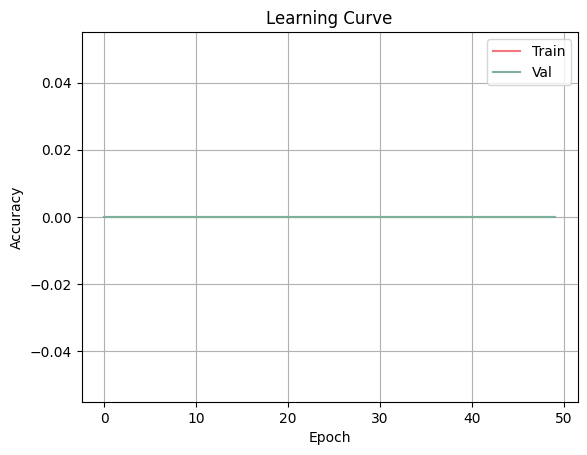

In [47]:
# первый этап обучения
with open("models/TokenCLF/freeze/info.json", "r") as info_file:
    info = json.load(info_file)
plot_lurning_curve(info["train_accuracy"], info["valid_accuracy"], "Accuracy")

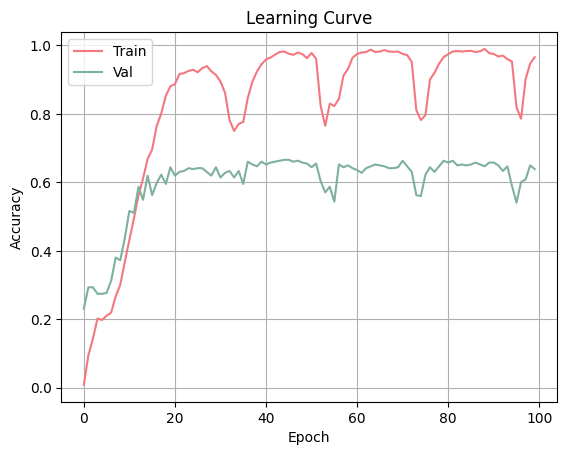

In [48]:
# второй этап обучения
with open("models/TokenCLF/unfreeze/info.json", "r") as info_file:
    info = json.load(info_file)
plot_lurning_curve(info["train_accuracy"], info["valid_accuracy"], "Accuracy")

На этот раз мы видим, что модель сильно переобучается: когда лосс около 0 и метрика близка к 1 на тренировочных данных, на валидации лосс и метрика почти не меняется. В итоге на валидационных данных модель показывает accuracy около 0.6.

### 3. Rule-based подход

Если внимательно посмотреть на датасет, можно заметить, что многие документы имеют одинаковую структуру и в целом очень похожи между собой. Это позволяет думать о том, что к нашей задаче можно применить правиловый подход, основанный на регулярных выражениях. 

В рамках данного мини-исследования не удалось собрать достаточно правил для хорошей метрики, но некоторые успехи у такого подхода есть. Ниже представлены правила для поиска нужных фрагментов в текстах с лейблом `обеспечение исполнения контракта`. Всего 4 регулярных выражения покрывают 26% от текстов с данным лейблом, что говорит о том, что у правилового подхода есть определенный потенциал.

In [49]:
import re
accuracy_score = 0
all_score = 0

regex_1 = "Размер обеспечени[ея] исполнения [кК]онтракта[^А-ЙЛ-ПС-ЯЁ]+(?=[А-ЙЛ-ПС-ЯЁ])"
regex_2 = "Размер обеспечени[ея] исполнения [дД]оговора[^А-ЙЛ-ПС-ЯЁ]+(?= [А-ЙЛ-ПС-ЯЁ])"
regex_3 = "Обеспечение исполнения настоящего [кК]онтракта[^А-ЙЛ-ПС-ЯЁ]+(?= [А-ЙЛ-ПС-ЯЁ])"
regex_4 = "Обеспечение исполнения настоящего [дД]оговора[^А-ЙЛ-ПС-ЯЁ]+(?= [А-ЙЛ-ПС-ЯЁ])"

for data in train_datas:
    if data["label"] == "обеспечение исполнения контракта":
        all_score += 1
        result_1 = re.findall(regex_1, data["text"])
        result_2 = re.findall(regex_2, data["text"])
        result_3 = re.findall(regex_3, data["text"])
        result_4 = re.findall(regex_4, data["text"])
        if result_1:
            if result_1[0].strip() == data["extracted_part"]["text"][0]:
                accuracy_score += 1
        elif result_2:
            if result_2[0].strip() == data["extracted_part"]["text"][0]:
                accuracy_score += 1
        elif result_3:
            if result_3[0].strip() == data["extracted_part"]["text"][0]:
                accuracy_score += 1
        elif result_4:
            if result_4[0].strip() == data["extracted_part"]["text"][0]:
                accuracy_score += 1
print(accuracy_score / all_score)

0.26214574898785425


### 4. Sentence Similarity

Еще один способ решения данной задачи - Sentence Similarity подход (определение меры схожести двух предложений). Модели, обученные на такую задачу, покрывают семантическую информацию предложений и рассчитывают, насколько она близка для пары предложений. В нашем случае можно было бы определять, насколько каждое предложение в тексте близко запросу (или лейблу). Однако, в силу того, что мы сильно зависим от конкретного фрагмента, а тексты не поделены заранее на предложения (и сделать это самим сложно в силу специфики документов, не имеющих часто даже знаков препинания), то таким способом в данный момент решить задачу затруднительно. Но если поработать над тем, чтобы преобразовать датасет в набор из предложений (и поиск фрагмента проводить по ним), то эксперименты с Sentence Similaruty будут иметь смысл.

## Часть 3. Результаты

В итоге модель, обученная решать задачу Extractive QA, показывает наилучшие результаты, поэтому в файл `predictions.json` мы сохраним результаты работы именно данной модели.

In [50]:
def run_inference(test_datas, tokenizer, model):

    predictions = []
    for data in test_datas:

        label = data["label"]
        text = data["text"]

        tokens = tokenizer(
            label,
            text,
            return_tensors="pt", 
            return_offsets_mapping=True
        )

        model.eval()
        with torch.no_grad():
            input_ids = tokens["input_ids"].to(DEVICE)
            mask = tokens["attention_mask"].to(DEVICE)
            start_logits, end_logits = model(input_ids, mask)
            start_pred = start_logits.argmax(1).to("cpu")
            end_pred = end_logits.argmax(1).to("cpu")
        offset_mapping = tokens["offset_mapping"]
        start_token = int(start_pred[0])
        end_token = int(end_pred[0])
        if start_token == 0 and end_token == 0:
            answer = ""
        else:
            start_char = offset_mapping[0][start_token][0]
            end_char = offset_mapping[0][end_token][1]
            answer = text[start_char:end_char]

        data["extracted_part"] = {
            "text": [answer],
            "answer_start": [int(start_char)],
            "answer_end": [int(end_char)]
        }

        predictions.append(data)

    return predictions

In [52]:
model = EQA_train.ExtractiveQAModel(model_bert, num_classes=2, dropout=0.5).to(DEVICE)
model_path = "models/ExtractiveQA/unfreeze/state_dict_model.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [53]:
predictions = run_inference(test_datas, tokenizer=tokenizer, model=model)

with open("../predictions.json", "w") as f:
    f.write(json.dumps(predictions, ensure_ascii=False, indent=2))